<a href="https://colab.research.google.com/github/s-islamovic/Neural-Networks-Prescriptive-Analytics-Project/blob/main/NeuralNetworksProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data_preprocessing.py

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving creditcard.csv to creditcard (2).csv


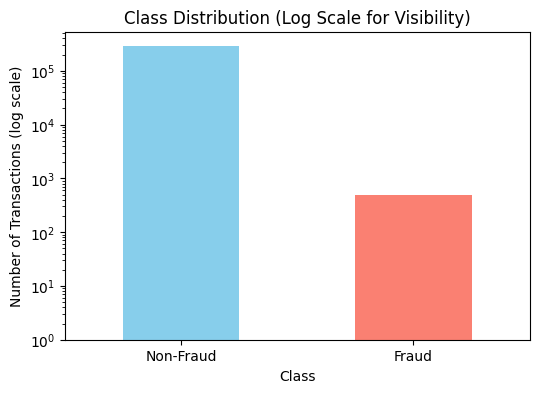

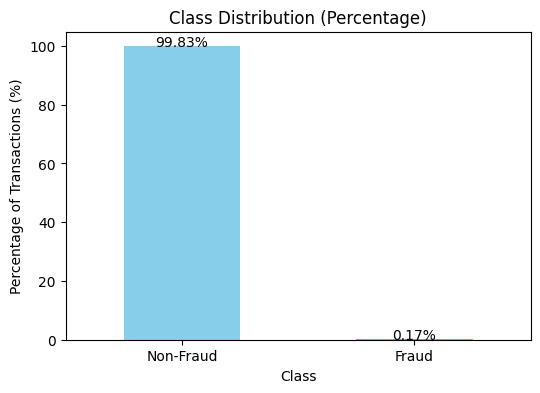

In [ ]:
 import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv("/content/creditcard.csv")

# Count transactions per class
class_counts = data['Class'].value_counts()
total = class_counts.sum()
percentages = class_counts / total * 100

# Plot absolute counts with log scale
plt.figure(figsize=(6,4))
class_counts.plot(kind='bar', color=['skyblue','salmon'], log=True)
plt.xticks([0,1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.ylabel('Number of Transactions (log scale)')
plt.title('Class Distribution (Log Scale for Visibility)')
plt.show()

# Plot percentages for easier interpretation
plt.figure(figsize=(6,4))
percentages.plot(kind='bar', color=['skyblue','salmon'])
plt.xticks([0,1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.ylabel('Percentage of Transactions (%)')
plt.title('Class Distribution (Percentage)')
for i, p in enumerate(percentages):
    plt.text(i, p + 0.05, f"{p:.2f}%", ha='center')
plt.show()



In [ ]:


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def load_data(path="/content/creditcard.csv"):
    data = pd.read_csv(path)

    X = data.drop("Class", axis=1)
    y = data["Class"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test


baseline_model.py

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(input_dim, lr=0.001, dropout_rate=0.2, hidden_units=32):
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(hidden_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


genetic_algorithm_optimization.py



In [ ]:
import os
print(os.listdir())


['.config', 'creditcard (2).csv', 'autoenconder.py', 'evaluation.py', 'genetic_algorithm_optimization.py', 'baseline_model.py', 'creditcard.csv', 'data_preprocessing.py', '__pycache__', 'creditcard (1).csv', 'sample_data']


In [ ]:
import random
import numpy as np
from baseline_model import build_model
from tensorflow.keras.callbacks import EarlyStopping

# Genetic Algorithm class for hyperparameter optimization of a neural network
class GeneticAlgorithm:
    def __init__(self, X_train, y_train, population_size=6, generations=4):
        """
        Initialize the Genetic Algorithm.

        Parameters:
        - X_train, y_train: training data
        - population_size: number of individuals in each generation
        - generations: number of generations to evolve
        """
        self.X_train = X_train
        self.y_train = y_train
        self.population_size = population_size
        self.generations = generations

        # Define possible hyperparameter choices for the neural network
        self.param_choices = {
            "lr": [0.0005, 0.001, 0.005],           # Learning rate options
            "dropout_rate": [0.1, 0.2, 0.3],       # Dropout rates for regularization
            "hidden_units": [16, 32, 64],          # Number of units in hidden layer
            "batch_size": [128, 256],              # Batch size during training
            "epochs": [5]                           # Number of epochs to train
        }

    # Generate a random individual (set of hyperparameters)
    def random_individual(self):
        return {
            "lr": random.choice(self.param_choices["lr"]),
            "dropout_rate": random.choice(self.param_choices["dropout_rate"]),
            "hidden_units": random.choice(self.param_choices["hidden_units"]),
            "batch_size": random.choice(self.param_choices["batch_size"]),
            "epochs": random.choice(self.param_choices["epochs"])
        }

    # Evaluate the fitness of an individual (hyperparameters)
    def fitness(self, params):
        """
        Fitness function: trains the model with given hyperparameters
        and returns the validation accuracy of the last epoch.
        """
        # Build the neural network model with given hyperparameters
        model = build_model(
            input_dim=self.X_train.shape[1],
            lr=params["lr"],
            dropout_rate=params["dropout_rate"],
            hidden_units=params["hidden_units"]
        )

        # Train the model
        history = model.fit(
            self.X_train, self.y_train,
            batch_size=params["batch_size"],
            epochs=params["epochs"],
            validation_split=0.2,    # Use 20% of training data for validation
            verbose=0,               # Suppress training output
            callbacks=[EarlyStopping(patience=2)]  # Stop early if no improvement
        )

        # Return validation accuracy of the last epoch as fitness score
        return history.history["val_accuracy"][-1]

    # Mutate an individual by randomly changing one hyperparameter
    def mutate(self, individual):
        """
        Randomly changes one hyperparameter in the individual.
        Mutation introduces diversity in the population.
        """
        key = random.choice(list(self.param_choices.keys()))
        individual[key] = random.choice(self.param_choices[key])
        return individual

    # Crossover between two parent individuals to create a child
    def crossover(self, parent1, parent2):
        """
        Combines hyperparameters from two parents.
        Each hyperparameter is randomly selected from either parent.
        """
        child = {}
        for key in parent1:
            child[key] = parent1[key] if random.random() > 0.5 else parent2[key]
        return child

    # Main GA loop: evolve the population over generations
    def evolve(self):
        """
        Run the genetic algorithm to find the best hyperparameters.
        Returns the best parameter set found.
        """
        # Step 1: Initialize population with random individuals
        population = [self.random_individual() for _ in range(self.population_size)]

        # Step 2: Evolve over multiple generations
        for gen in range(self.generations):
            print(f"\n--- Generation {gen+1} ---")

            # Evaluate fitness for all individuals in the population
            scores = [(params, self.fitness(params)) for params in population]

            # Sort individuals by fitness in descending order (higher is better)
            scores.sort(key=lambda x: x[1], reverse=True)

            # Keep the top 2 individuals as "best"
            best = scores[:2]
            print("Best so far:", best)

            # Step 3: Create next generation
            next_gen = [s[0] for s in best]  # Start with best two

            # Fill the rest of the population using crossover and mutation
            while len(next_gen) < self.population_size:
                parent1, parent2 = random.sample(best, 2)   # Randomly select two parents
                child = self.crossover(parent1[0], parent2[0])  # Create child
                if random.random() < 0.3:                     # 30% chance of mutation
                    child = self.mutate(child)
                next_gen.append(child)

            # Update population for next generation
            population = next_gen

        # Step 4: Return the best hyperparameters found
        best_params = best[0][0]
        print("\nBest Parameters:", best_params)
        return best_params


autoencoder.py

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)

    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder


evaluation.py

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    preds = (preds > 0.5).astype(int)

    print("\nCONFUSION MATRIX:\n", confusion_matrix(y_test, preds))
    print("\nREPORT:\n", classification_report(y_test, preds))
    print("AUC:", roc_auc_score(y_test, preds))


train.py


--- Generation 1 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best so far: [({'lr': 0.001, 'dropout_rate': 0.2, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.99942946434021), ({'lr': 0.001, 'dropout_rate': 0.2, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.9993855357170105)]

--- Generation 2 ---
Best so far: [({'lr': 0.001, 'dropout_rate': 0.1, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.999495267868042), ({'lr': 0.001, 'dropout_rate': 0.2, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.9994733333587646)]

--- Generation 3 ---
Best so far: [({'lr': 0.001, 'dropout_rate': 0.1, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.9995611310005188), ({'lr': 0.001, 'dropout_rate': 0.2, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.9994733333587646)]

--- Generation 4 ---
Best so far: [({'lr': 0.001, 'dropout_rate': 0.2, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.9995391368865967), ({'lr': 0.001, 'dropout_rate': 0.2, 'hidden_units': 64, 'batch_size': 128, 'epochs': 5}, 0.9994513988494873)]



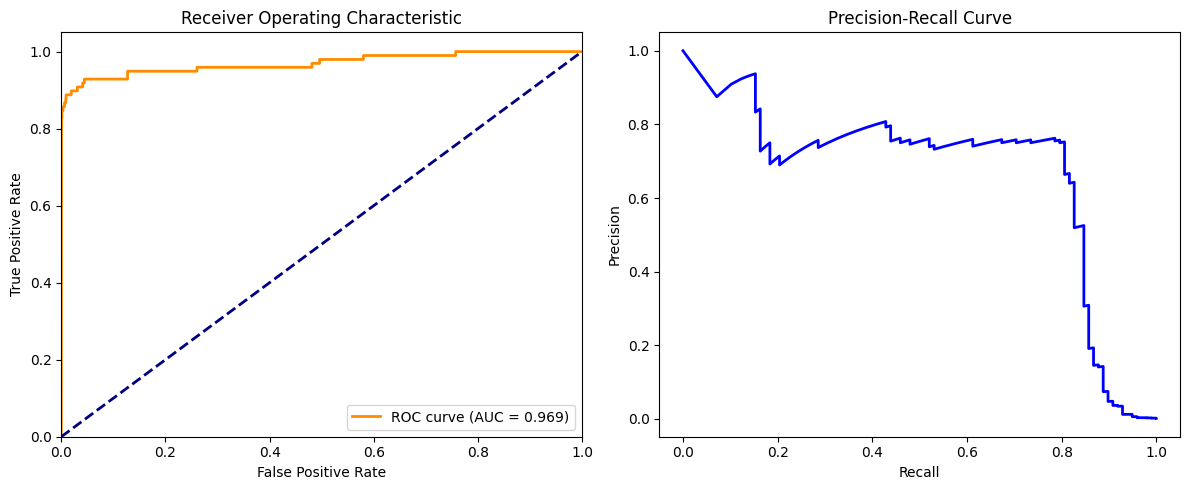

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from data_preprocessing import load_data
from baseline_model import build_model
from genetic_algorithm_optimization import GeneticAlgorithm
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from evaluation import evaluate_model

def plot_roc_pr(y_test, y_pred_probs):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    plt.subplot(1,2,2)
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    plt.tight_layout()
    plt.show()

def main():
    # Load data
    X_train, X_test, y_train, y_test = load_data(path="/content/creditcard.csv")  # adjust path if needed

    # Run GA to get best hyperparameters
    ga = GeneticAlgorithm(X_train, y_train)
    best_params = ga.evolve()

    print("\nTraining final model with GA-optimized parameters...")
    model = build_model(
        input_dim=X_train.shape[1],
        lr=best_params["lr"],
        dropout_rate=best_params["dropout_rate"],
        hidden_units=best_params["hidden_units"]
    )

    # Define class weights to handle imbalance
    class_weight = {0: 1, 1: 50}  # gives more weight to fraud class

    model.fit(
        X_train, y_train,
        batch_size=best_params["batch_size"],
        epochs=best_params["epochs"],
        validation_split=0.2,
        verbose=1,
        class_weight=class_weight
    )

    # Evaluate
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)

    print("\nEVALUATION METRICS:")
    evaluate_model(model, X_test, y_test)

    # Plot ROC and Precision-Recall curves
    plot_roc_pr(y_test, y_pred_probs)

if __name__ == "__main__":
    main()
